In [1]:
from scripts import setup_environment

setup_environment()

In [2]:
from scripts.dataset import BrainteaserDataset

dataset = BrainteaserDataset("data")

In [3]:
import string

from scripts.dataset import RiddleQuestion
from scripts.prompt_helpers import create_prompt_template


def args_generator(riddle_question: RiddleQuestion):
    template_args = {
        "question": riddle_question.question,
        "choices": "\n".join(
            [
                f"({string.ascii_uppercase[j]}) {choice}"
                for j, choice in enumerate(riddle_question.choice_list)
            ]
        ),
    }

    return template_args


chat_prompt_template = create_prompt_template("default")

In [4]:
from scripts.lmm import OllamaModelBuilder
from scripts.executor import Executor

base_url = "http://38.29.145.220:42001"
# Ensure that the temperature is set to 0.0f, otherwise the model could be unstable due to taking risks
# but this will also make the model less creative. As we are interested in the stability of the model, this is not a problem.
model_builder = OllamaModelBuilder(base_url, temperature=0)

executor = Executor(
    models=[
        # Llama3.1
        model_builder.build_model("llama3.1:8b"),
        # Llama3.2
        model_builder.build_model("llama3.2:1b"),
        model_builder.build_model("llama3.2:3b"),
        # Phi3.5
        model_builder.build_model("phi3.5:3.8b"),
        # Phi4
        model_builder.build_model("phi4:14b"),
        # Qwen2.5
        model_builder.build_model("qwen2.5:0.5b"),
        model_builder.build_model("qwen2.5:1.5b"),
        model_builder.build_model("qwen2.5:3b"),
        model_builder.build_model("qwen2.5:7b"),
        model_builder.build_model("qwen2.5:14b"),
        model_builder.build_model("qwen2.5:32b"),
        # Gemma2
        model_builder.build_model("gemma2:2b"),
        model_builder.build_model("gemma2:9b"),
        model_builder.build_model("gemma2:27b"),
        # Mistral Nemo
        model_builder.build_model("mistral-nemo:12b"),
    ]
)

2025-03-03 13:30:47,050 - INFO - Initialized executor with 15 models.


In [5]:
import numpy as np

from scripts.executor import Dataset

# Set fixed seed for reproducibility
np.random.seed(42)


def create_test_dataset(data: list[RiddleQuestion], name: str, percentage: float = 0.1):
    """Create a test dataset by randomly sampling a percentage of the original data."""
    indices = np.random.choice(
        len(data), size=int(len(data) * percentage), replace=False
    )
    return Dataset(name=name, riddles=[data[i] for i in indices])


# Create test datasets
sp_data = create_test_dataset(dataset.sp, "sp")
wp_data = create_test_dataset(dataset.wp, "wp")

# Prepare executor data
executor_data = [sp_data, wp_data]

In [6]:
total_results = {}

for run_index in range(5):
    chat_prompt_template = create_prompt_template("default")
    results = await executor.aexecute(
        executor_data,
        chat_prompt_template,
        args_generator,
        dump_to_pickle=True,
        create_checkpoints=True,
        resume_from_checkpoint=True,
        run_name="model_stability_test",
        file_name_suffix=f"run_{run_index}-temp-0",
    )
    total_results[run_index] = results

2025-03-03 13:30:47,070 - INFO - Starting execution 'model-stability-test with suffix 'run_0-temp-0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-0-temp-0):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-03 13:54:38,834 - INFO - Saving results to results/model-stability-test/model-stability-test_run-0-temp-0_results.pkl
2025-03-03 13:54:39,223 - INFO - Execution 'model-stability-test with suffix 'run_0-temp-0'' completed successfully.
2025-03-03 13:54:39,224 - INFO - Starting execution 'model-stability-test with suffix 'run_1-temp-0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-1-temp-0):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-03 14:12:00,053 - INFO - Saving results to results/model-stability-test/model-stability-test_run-1-temp-0_results.pkl
2025-03-03 14:12:00,464 - INFO - Execution 'model-stability-test with suffix 'run_1-temp-0'' completed successfully.
2025-03-03 14:12:00,465 - INFO - Starting execution 'model-stability-test with suffix 'run_2-temp-0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-2-temp-0):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-03 14:31:54,564 - INFO - Saving results to results/model-stability-test/model-stability-test_run-2-temp-0_results.pkl
2025-03-03 14:31:55,017 - INFO - Execution 'model-stability-test with suffix 'run_2-temp-0'' completed successfully.
2025-03-03 14:31:55,018 - INFO - Starting execution 'model-stability-test with suffix 'run_3-temp-0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-3-temp-0):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-03 14:50:38,482 - INFO - Saving results to results/model-stability-test/model-stability-test_run-3-temp-0_results.pkl
2025-03-03 14:50:38,945 - INFO - Execution 'model-stability-test with suffix 'run_3-temp-0'' completed successfully.
2025-03-03 14:50:38,946 - INFO - Starting execution 'model-stability-test with suffix 'run_4-temp-0'': 2 dataset(s) x 15 model(s) = 1665 riddle evaluations


model-stability-test(run-4-temp-0):   0%|          | 0/1665 [00:00<?, ?it/s]

2025-03-03 15:10:35,667 - INFO - Saving results to results/model-stability-test/model-stability-test_run-4-temp-0_results.pkl
2025-03-03 15:10:35,963 - INFO - Execution 'model-stability-test with suffix 'run_4-temp-0'' completed successfully.


## Eval results


In [2]:
import os
import glob
import pickle
from pathlib import Path


def load_results(glob_pattern: str):
    results_dir = Path("results/model-stability-test")
    result_files = glob.glob(str(results_dir / glob_pattern))

    # Load all results into a dictionary
    # The first key is the suffix (technique name)
    total_results = {}

    for file_path in result_files:
        # Extract the suffix from the filename
        suffix = os.path.basename(file_path).split("_")[1]

        # Load the results from the pickle file
        with open(file_path, "rb") as f:
            wrapped_results = pickle.load(f)
            total_results[suffix] = wrapped_results.results

    print(f"Loaded {len(total_results)} result sets from disk.")
    return total_results


total_results_temp_0 = load_results("model-stability-test_run-[0-4]-temp-0_results.pkl")
total_results_temp_default = load_results(
    "model-stability-test_run-[0-4]-temp-default_results.pkl"
)

Loaded 5 result sets from disk.
Loaded 5 result sets from disk.


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scripts.evaluation import eval_model_results


def check_model_stability(total_results):
    model_stability = {}
    dataset_stability = {}

    run_names = list(total_results.keys())
    if not run_names:
        return {"error": "No runs found in results"}

    first_run = total_results[run_names[0]]
    datasets = list(first_run.keys())

    for dataset_name in datasets:
        models = list(first_run[dataset_name].keys())
        dataset_stability[dataset_name] = {}

        for model_name in models:
            run_scores = []
            for run_name in run_names:
                run_results = total_results[run_name]

                if (
                    dataset_name not in run_results
                    or model_name not in run_results[dataset_name]
                ):
                    continue

                run_score = eval_model_results(run_results[dataset_name][model_name])
                run_scores.append(run_score)

            if not run_scores:
                continue

            average_score = sum(run_scores) / len(run_scores)
            stability_score = (
                1 - (np.std(run_scores) / average_score) if average_score > 0 else 0
            )

            dataset_stability[dataset_name][model_name] = {
                "stability_score": stability_score,
                "average_score": average_score,
                "run_scores": run_scores,
            }

            if model_name not in model_stability:
                model_stability[model_name] = {}
            model_stability[model_name][dataset_name] = dataset_stability[dataset_name][
                model_name
            ]

    return {"by_dataset": dataset_stability, "by_model": model_stability}


def display_model_stability_analysis(stability_results):
    print("Model Stability Analysis\n")
    print("=" * 80)

    for model_name, datasets in stability_results["by_model"].items():
        print(f"\nModel: {model_name}")
        print("-" * 80)

        for dataset_name, metrics in datasets.items():
            stability = metrics["stability_score"]
            average_score = metrics["average_score"]
            run_scores = metrics["run_scores"]

            print(f"  Dataset: {dataset_name}")
            print(
                f"    Stability Score: {stability:.2f}, Average Score: {average_score:.2f}"
            )

            print(f"    Run Scores: {run_scores}")

    model_names = list(stability_results["by_model"].keys())
    dataset_names = list(stability_results["by_dataset"].keys())

    stability_matrix = np.zeros((len(model_names), len(dataset_names)))

    for i, model_name in enumerate(model_names):
        for j, dataset_name in enumerate(dataset_names):
            if dataset_name in stability_results["by_model"][model_name]:
                stability_matrix[i, j] = stability_results["by_model"][model_name][
                    dataset_name
                ]["stability_score"]

    plt.figure(figsize=(12, 10))
    sns.heatmap(
        stability_matrix,
        annot=True,
        fmt=".1f",
        cmap="YlGnBu",
        xticklabels=dataset_names,
        yticklabels=model_names,
    )
    plt.title("Model Stability Across Datasets (Stability Score)")
    plt.ylabel("Model")
    plt.xlabel("Dataset")
    plt.tight_layout()
    plt.show()

## Temperature (0.0)


Model Stability Analysis


Model: llama3.1:8b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability Score: 0.96, Average Score: 43.23
    Run Scores: [45.16129032258064, 40.32258064516129, 45.16129032258064, 41.935483870967744, 43.54838709677419]
  Dataset: wp
    Stability Score: 0.98, Average Score: 50.20
    Run Scores: [51.02040816326531, 48.97959183673469, 48.97959183673469, 51.02040816326531, 51.02040816326531]

Model: llama3.2:1b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability Score: 1.00, Average Score: 8.06
    Run Scores: [8.064516129032258, 8.064516129032258, 8.064516129032258, 8.064516129032258, 8.064516129032258]
  Dataset: wp
    Stability Score: 1.00, Average Score: 2.04
    Run Scores: [2.0408163265306123, 2.0408163265306123, 2.0408163265306123, 2.0408163265306123, 2.0408163265306123]

Model: llama3.2:3b
----------------------------------------------------

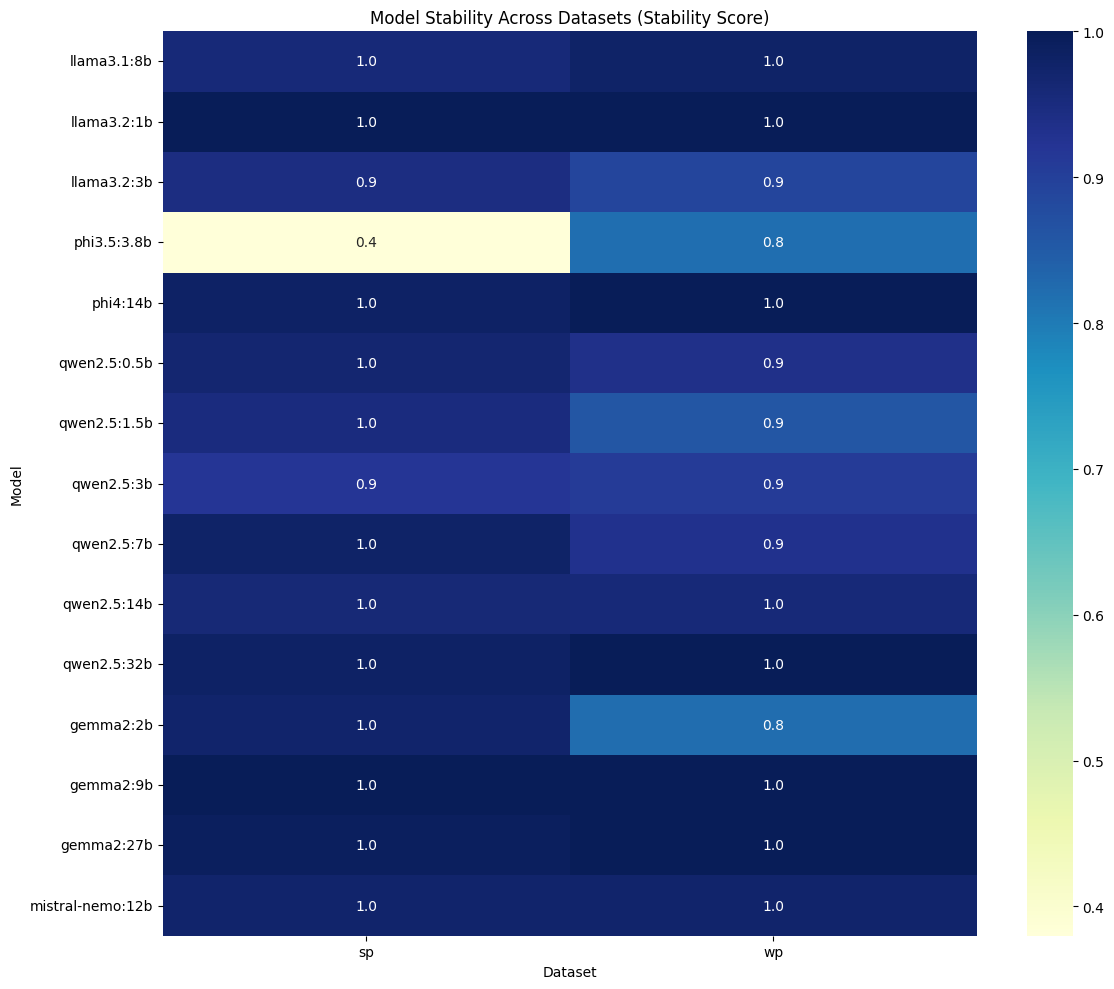

In [4]:
stability_results_temp_0 = check_model_stability(total_results_temp_0)
display_model_stability_analysis(stability_results_temp_0)

## Temperature (0.8 (default))


Model Stability Analysis


Model: llama3.1:8b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability Score: 0.95, Average Score: 43.87
    Run Scores: [48.38709677419355, 41.935483870967744, 41.935483870967744, 43.54838709677419, 43.54838709677419]
  Dataset: wp
    Stability Score: 0.87, Average Score: 51.02
    Run Scores: [59.183673469387756, 53.06122448979592, 38.775510204081634, 53.06122448979592, 51.02040816326531]

Model: llama3.2:1b
--------------------------------------------------------------------------------
  Dataset: sp
    Stability Score: 1.00, Average Score: 8.06
    Run Scores: [8.064516129032258, 8.064516129032258, 8.064516129032258, 8.064516129032258, 8.064516129032258]
  Dataset: wp
    Stability Score: 1.00, Average Score: 2.04
    Run Scores: [2.0408163265306123, 2.0408163265306123, 2.0408163265306123, 2.0408163265306123, 2.0408163265306123]

Model: llama3.2:3b
-------------------------------------------------

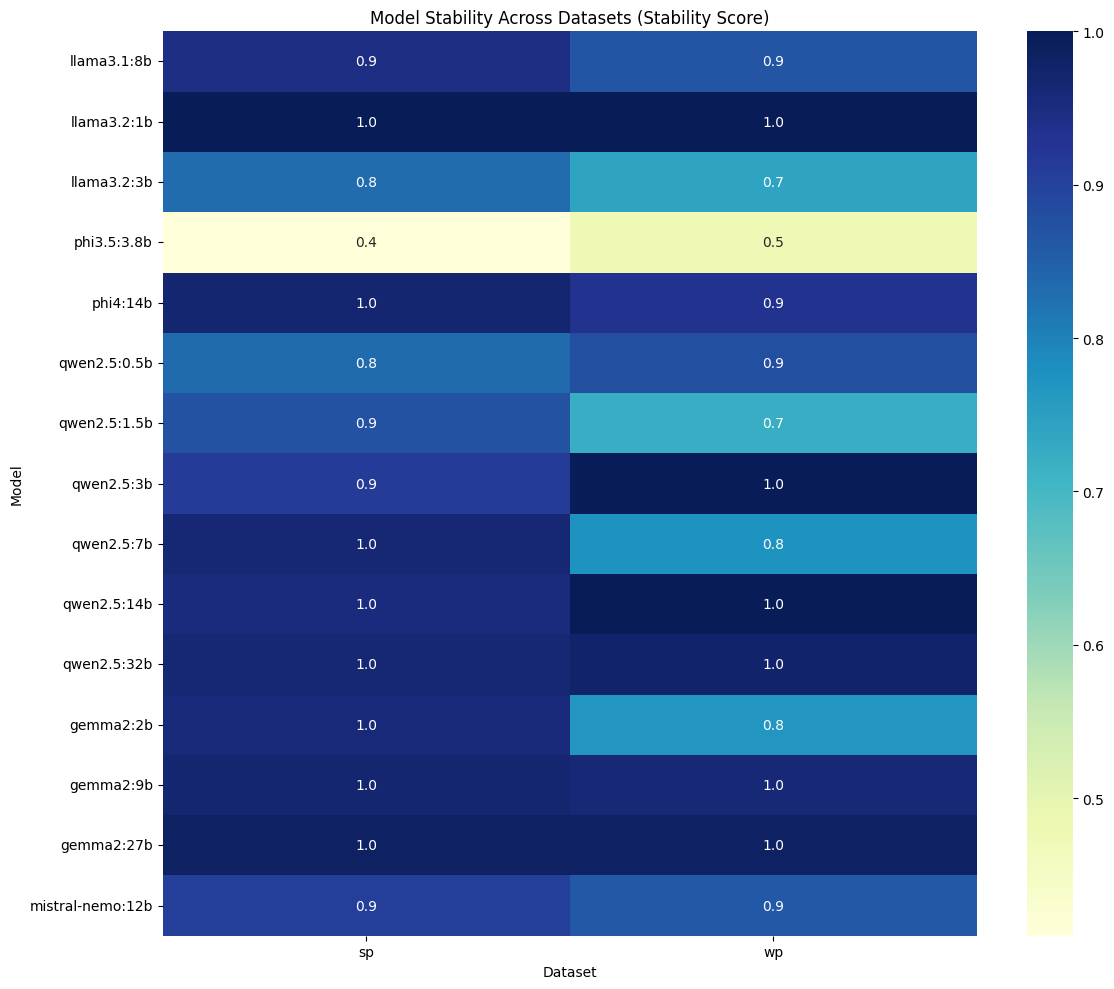

In [5]:
stability_results_temp_default = check_model_stability(total_results_temp_default)
display_model_stability_analysis(stability_results_temp_default)

Average Model Accuracy Comparison (Temperature 0.0 vs 0.8)


,Model,Accuracy (Temp=0.0),Accuracy (Temp=0.8),Difference
0,llama3.1:8b,46.714944,47.445688,-0.730744
1,llama3.2:1b,5.052666,5.052666,0.000000
2,llama3.2:3b,29.749835,24.792627,4.957209
3,phi3.5:3.8b,25.092166,13.811718,11.280448
4,phi4:14b,60.348914,57.952600,2.396313
5,qwen2.5:0.5b,17.271231,18.699803,-1.428571
6,qwen2.5:1.5b,13.341014,16.705069,-3.364055
7,qwen2.5:3b,15.671494,16.767610,-1.096116
8,qwen2.5:7b,36.886109,35.789993,1.096116
9,qwen2.5:14b,22.290981,22.570770,-0.279789


<Figure size 1200x1000 with 0 Axes>

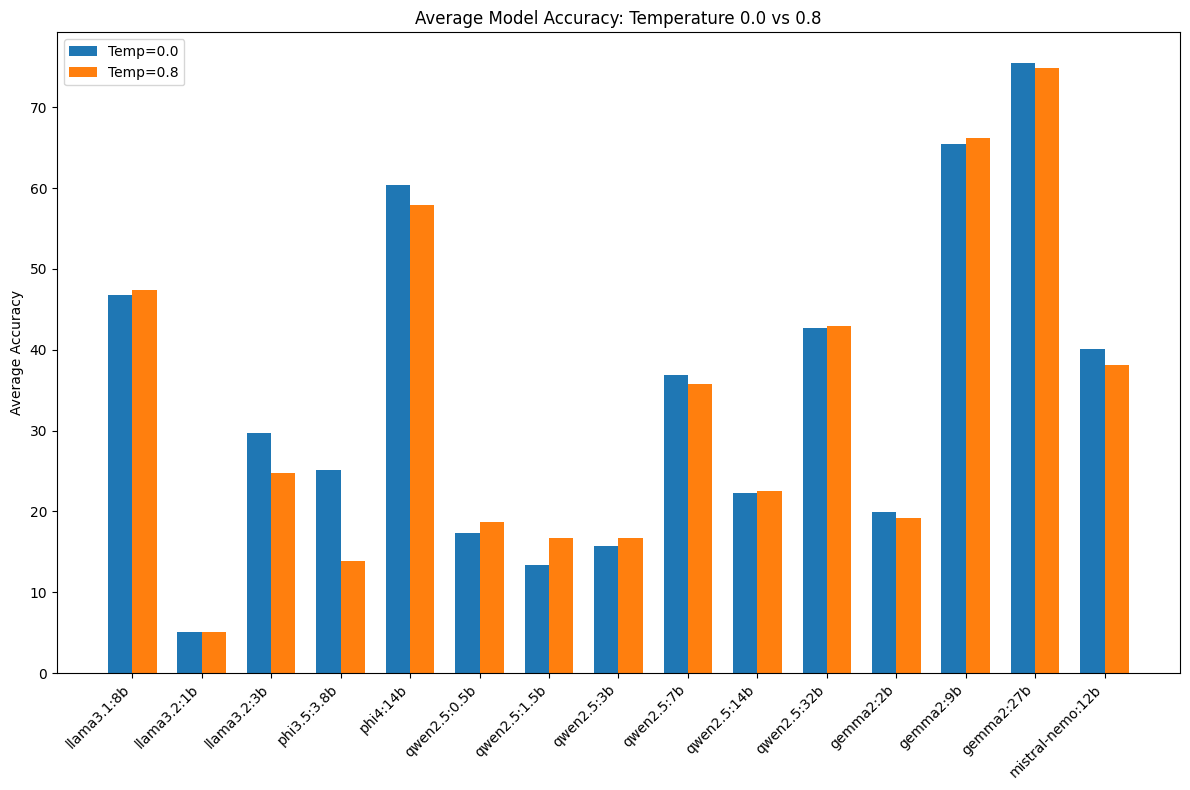

Overall average accuracy difference (Temp 0.0 - Temp 0.8): 1.0237
Paired t-test results: t-statistic = 1.1594, p-value = 0.2657
The difference is not statistically significant at α=0.05


In [7]:
import pandas as pd
from scipy import stats

accuracy_temp_0 = {}
accuracy_temp_default = {}

for model_name in stability_results_temp_0["by_model"]:
    model_accuracy_temp_0 = []
    model_accuracy_temp_default = []

    for dataset_name in stability_results_temp_0["by_model"][model_name]:
        if dataset_name in stability_results_temp_0["by_model"][model_name]:
            model_accuracy_temp_0.append(
                stability_results_temp_0["by_model"][model_name][dataset_name][
                    "average_score"
                ]
            )

        if dataset_name in stability_results_temp_default["by_model"][model_name]:
            model_accuracy_temp_default.append(
                stability_results_temp_default["by_model"][model_name][dataset_name][
                    "average_score"
                ]
            )

    if model_accuracy_temp_0:
        accuracy_temp_0[model_name] = np.mean(model_accuracy_temp_0)

    if model_accuracy_temp_default:
        accuracy_temp_default[model_name] = np.mean(model_accuracy_temp_default)

# Create a comparison dataframe
comparison_data = {
    "Model": list(accuracy_temp_0.keys()),
    "Accuracy (Temp=0.0)": list(accuracy_temp_0.values()),
    "Accuracy (Temp=0.8)": [
        accuracy_temp_default.get(model, np.nan) for model in accuracy_temp_0
    ],
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df["Difference"] = (
    comparison_df["Accuracy (Temp=0.0)"] - comparison_df["Accuracy (Temp=0.8)"]
)

# Display the comparison
print("Average Model Accuracy Comparison (Temperature 0.0 vs 0.8)")
display(comparison_df)

# Visualize the comparison
plt.figure(figsize=(12, 10))
models = comparison_df["Model"]
x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(
    x - width / 2, comparison_df["Accuracy (Temp=0.0)"], width, label="Temp=0.0"
)
rects2 = ax.bar(
    x + width / 2, comparison_df["Accuracy (Temp=0.8)"], width, label="Temp=0.8"
)

ax.set_ylabel("Average Accuracy")
ax.set_title("Average Model Accuracy: Temperature 0.0 vs 0.8")
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha="right")
ax.legend()

plt.tight_layout()
plt.show()

# Calculate the overall average difference
avg_diff = comparison_df["Difference"].mean()
print(f"Overall average accuracy difference (Temp 0.0 - Temp 0.8): {avg_diff:.4f}")

# Perform a paired t-test
t_stat, p_value = stats.ttest_rel(
    comparison_df["Accuracy (Temp=0.0)"].dropna(),
    comparison_df["Accuracy (Temp=0.8)"].dropna(),
)
print(f"Paired t-test results: t-statistic = {t_stat:.4f}, p-value = {p_value:.4f}")

# Determine statistical significance
significance = (
    "statistically significant" if p_value < 0.05 else "not statistically significant"
)
print(f"The difference is {significance} at alpha=0.05")